# **Categorical Feature Encoding Challenge II (or Cat in the dat II)**
**Binary classification, with every feature a categorical (and interactions!)**

I read lots of discussions from the Discussion section, so this is not all mine. I took ideas from too may different people to actually put all the references here, but if you check the discussion section, you will be able to tell where I took the ideas or pieces of code from.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# visualization
import seaborn as sns
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
sns.set_context("talk")
sns.set_palette('husl')
sns.set()

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

all_data = pd.concat((train.drop('target', axis=1), test))
all_data.drop('id', axis=1, inplace=True)

all_data.head(3)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,745b909d1,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0


In [3]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 399999
Data columns (total 24 columns):
id       1000000 non-null int64
bin_0    970205 non-null float64
bin_1    969959 non-null float64
bin_2    970098 non-null float64
bin_3    970035 non-null object
bin_4    970002 non-null object
nom_0    969686 non-null object
nom_1    969897 non-null object
nom_2    969786 non-null object
nom_3    969703 non-null object
nom_4    969972 non-null object
nom_5    970310 non-null object
nom_6    969857 non-null object
nom_7    969994 non-null object
nom_8    970289 non-null object
nom_9    969867 non-null object
ord_0    969819 non-null float64
ord_1    969792 non-null object
ord_2    969820 non-null object
ord_3    970031 non-null object
ord_4    970137 non-null object
ord_5    970240 non-null object
day      970023 non-null float64
month    970028 non-null float64
dtypes: float64(6), int64(1), object(17)
memory usage: 190.7+ MB


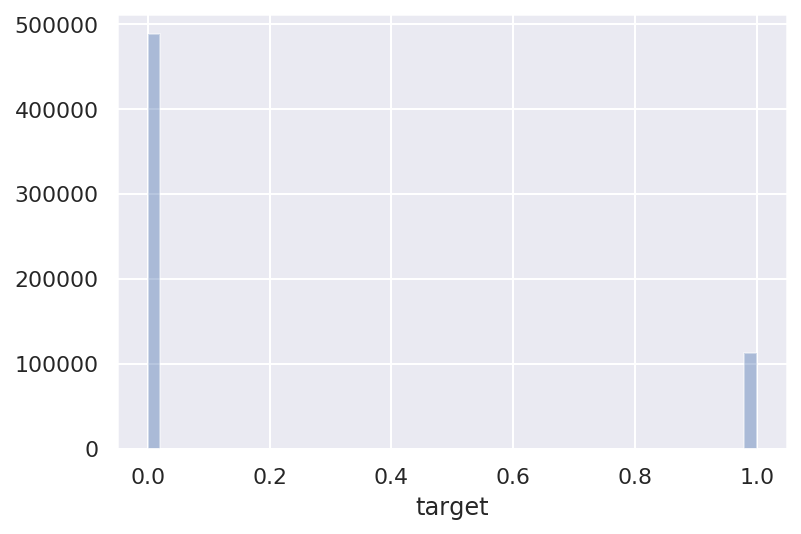

In [4]:
y = train['target']
sns.distplot(y, kde=False);

## Pre-Analysis

We have a million column and lots of missing data. However, the amount is still low compare to the total number of rows. We could drop all the rows with missing data, but if we do this, we drop have of our dataset, so we would need to use imputers.

The targets are inbalanced, so we will need to deal with this, but let's skip it for now.

In [3]:
numeric_index = all_data.dtypes[all_data.dtypes != "object"].index
categ_index = all_data.dtypes[all_data.dtypes == "object"].index

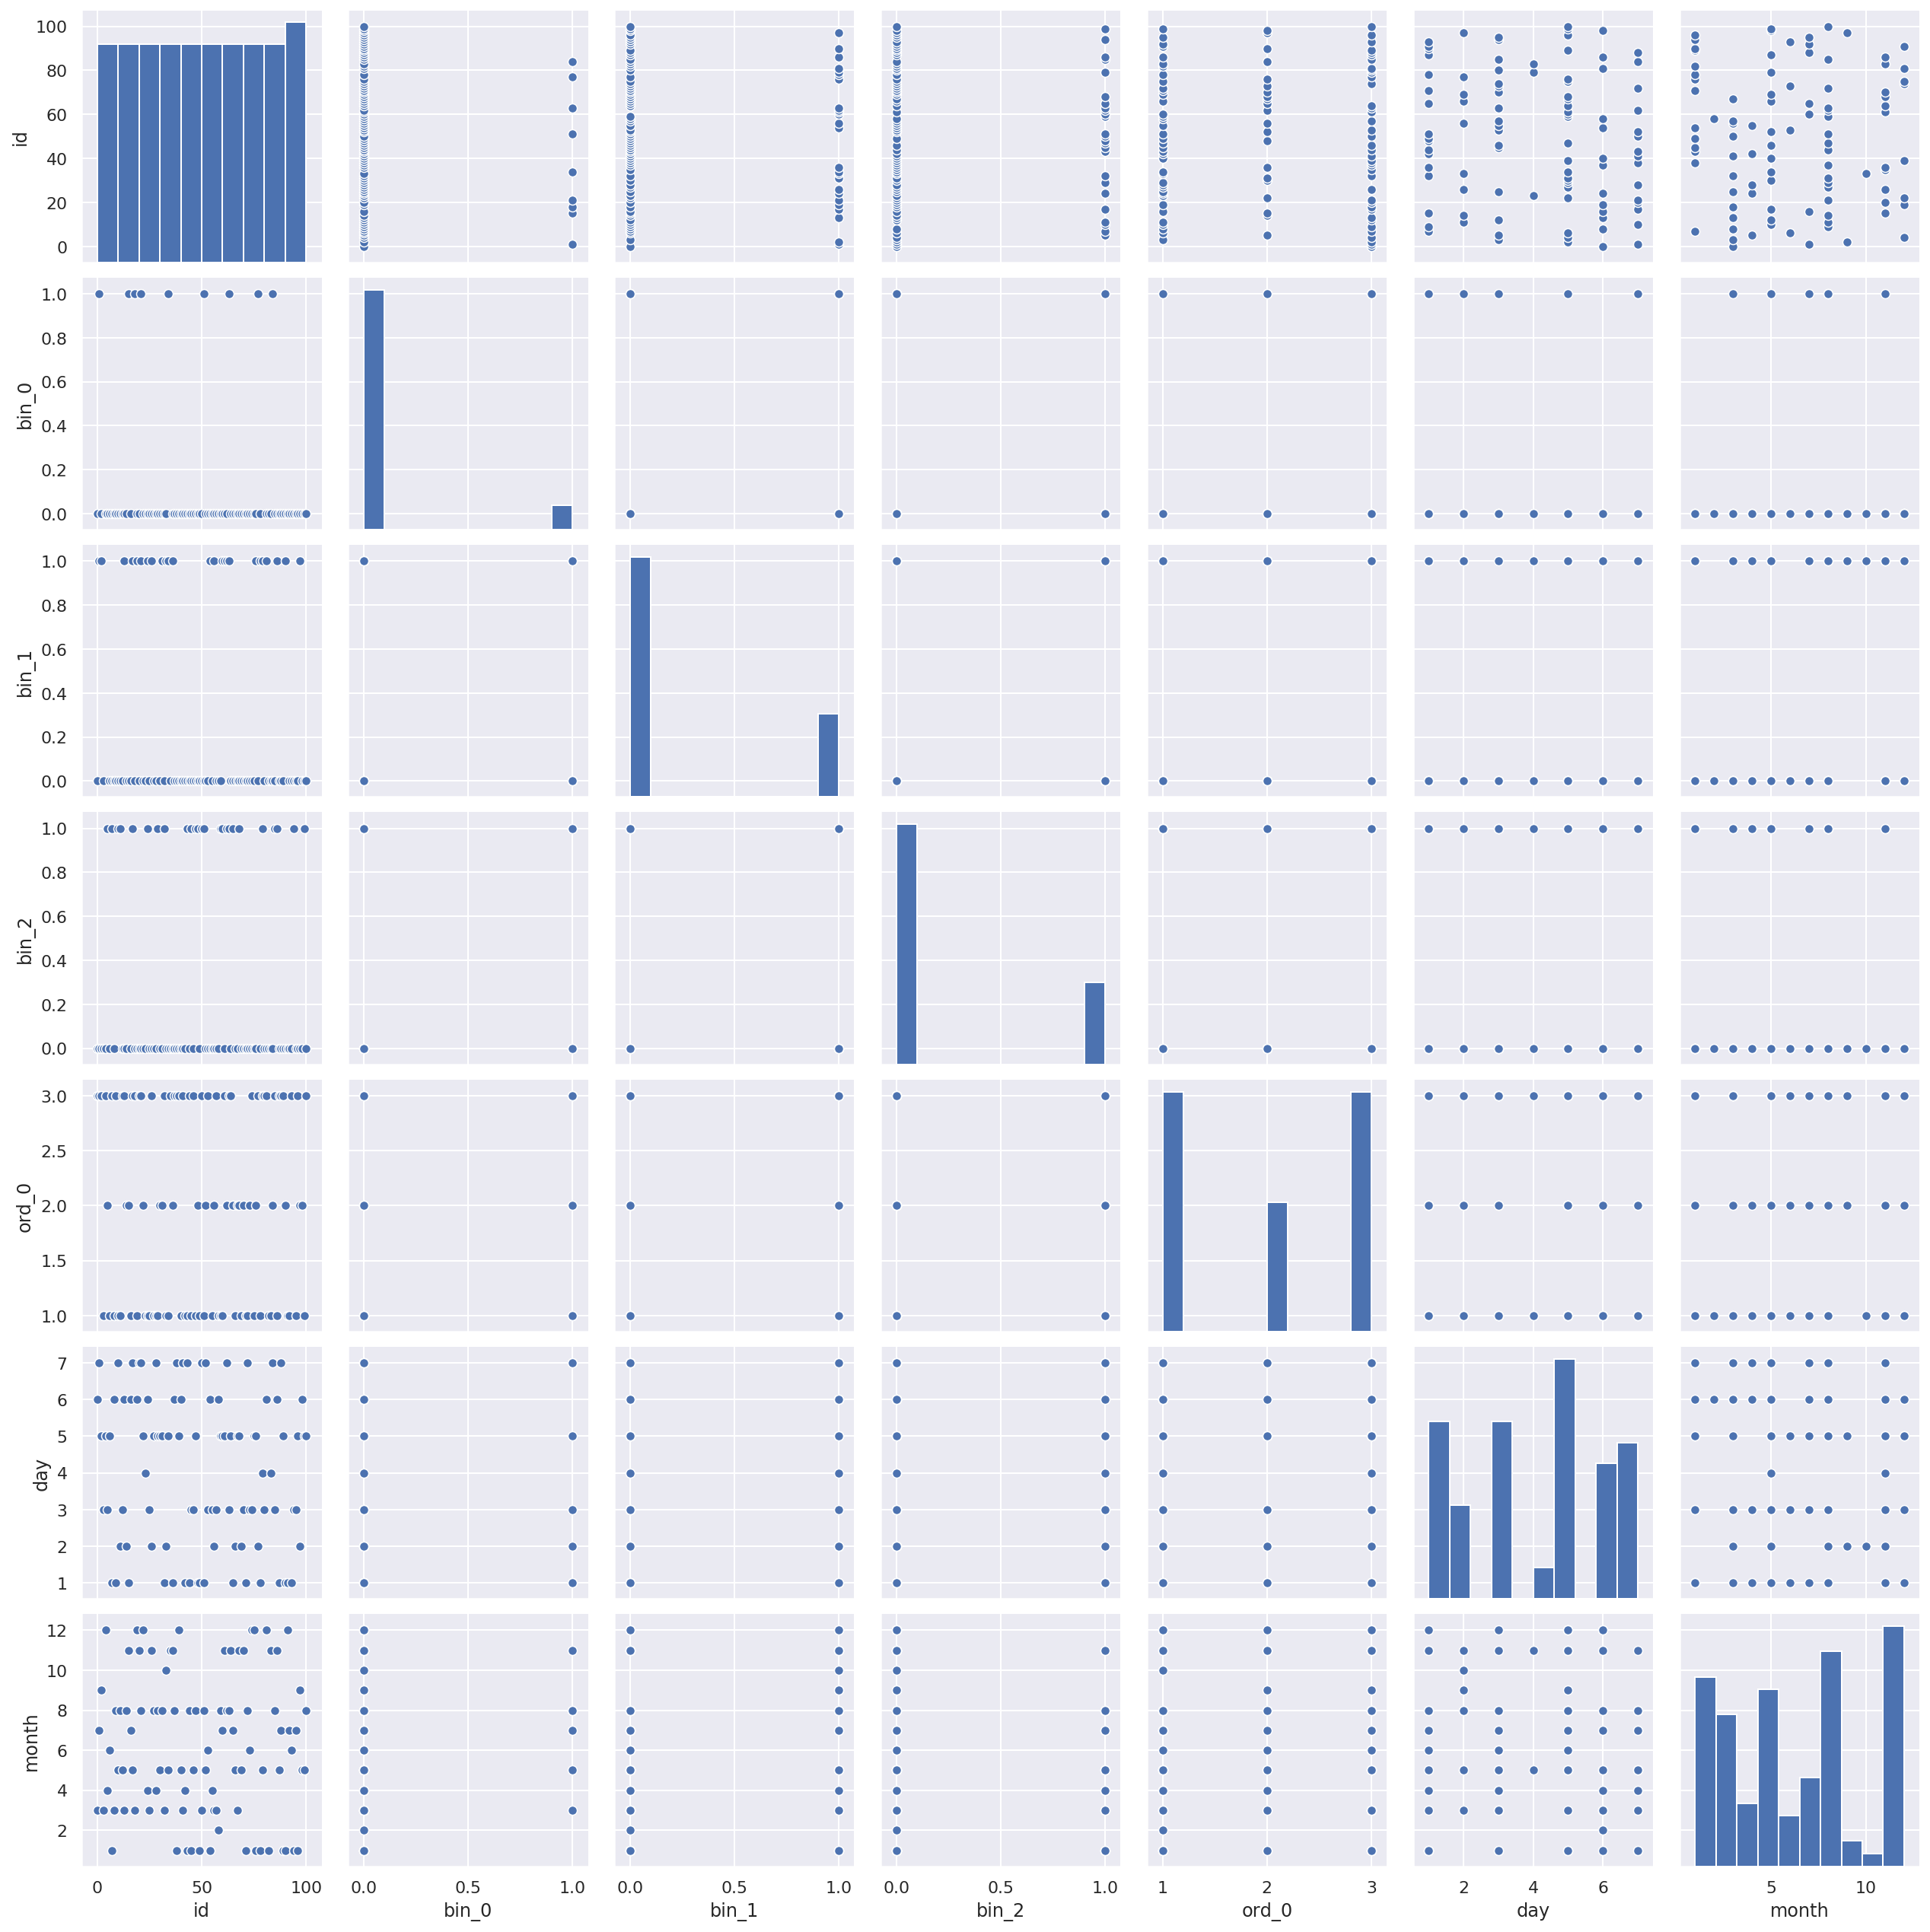

In [8]:
sns.pairplot(train[numeric_index].loc[:100]);

In [6]:
for col in all_data.columns:
    print(col, all_data[col].unique())

id [     0      1      2 ... 999997 999998 999999]
bin_0 [ 0.  1. nan]
bin_1 [ 0.  1. nan]
bin_2 [ 0.  1. nan]
bin_3 ['F' 'T' nan]
bin_4 ['N' 'Y' nan]
nom_0 ['Red' 'Blue' 'Green' nan]
nom_1 ['Trapezoid' 'Star' nan 'Circle' 'Triangle' 'Polygon' 'Square']
nom_2 ['Hamster' 'Axolotl' 'Lion' 'Dog' 'Cat' 'Snake' nan]
nom_3 ['Russia' nan 'Canada' 'Finland' 'Costa Rica' 'China' 'India']
nom_4 ['Bassoon' 'Theremin' nan 'Oboe' 'Piano']
nom_5 ['de4c57ee2' '2bb3c3e5c' 'b574c9841' ... 'b3ad70fcb' 'd6bb2181a'
 '30019ce8a']
nom_6 ['a64bc7ddf' '3a3a936e8' '708248125' ... 'a93b49b8c' 'd80c01ec8'
 'a885aacec']
nom_7 ['598080a91' '1dddb8473' '5ddc9a726' '3a33ef960' 'bc9cc2a94' '8c30b9b0b'
 '1cba571fa' '81d67e1bb' '429114096' '56d35c774' '93360bbc9' '088aace2d'
 '12370b989' 'ba9faf5b1' 'fdebf0648' '90a2cba07' '5de0b3fa7' 'e5b00a0e0'
 '1d2ee04de' nan '69403e18c' 'cf84cbe77' 'fba315672' '6e29d3f38'
 'c3ad85934' '6b1d5295a' 'a306b1f4e' '432ee0053' '9a9e7bf71' 'b2d0012ea'
 '9d52e9089' 'bb63fcef7' 'dd4d69481' 

We can see that numerical columns have discrete values, so no transformation is needed. We will also need to impute the data with mode as the mean will make no sense in this case.

In [111]:
all_data = pd.concat((train.drop('target', axis=1), test))
all_data.drop('id', axis=1, inplace=True)

In [112]:
# impute data (in a more eficient way than using sklearn imputers as this is a big dataset)
for col in all_data.columns:
    all_data[col].fillna(all_data[col].mode()[0], inplace=True)

In [113]:
# deal with cyclical data
all_data['day_sin'] = np.sin(all_data.day*(2.*np.pi/24))
all_data['day_cos'] = np.cos(all_data.day*(2.*np.pi/24))
all_data['month_sin'] = np.sin((all_data.month-1)*(2.*np.pi/12))
all_data['month_cos'] = np.cos((all_data.month-1)*(2.*np.pi/12))
all_data.drop(['day', 'month'], axis=1, inplace=True)

Check [this](https://www.kaggle.com/shahules/an-overview-of-encoding-techniques) for an encoding overview.

In [114]:
# Encoders
dtransf = {"ord_1":{'Novice':0, 'Contributor':1, 'Expert':2, 'Master':3, 'Grandmaster':4},
           "ord_2":{'Freezing':0, 'Cold':1, 'Warm':2, 'Hot':3, 'Boiling Hot':4, 'Lava Hot':5}
          }
for col in dtransf.keys():
    all_data[col] = [dtransf[col][cat_feat] for cat_feat in all_data[col]]

    
ohe = True
if ohe:
    # One-Hot Encoder
    encoder = OneHotEncoder()
    all_data = encoder.fit_transform(all_data)

else:
    # Label Encoder 
    encoder = LabelEncoder()
    all_data = all_data.apply(encoder.fit_transform)

In [134]:
X_train = all_data[:train.shape[0]].tocsr()
X_test = all_data[train.shape[0]:].tocsr()
y = train['target']

___
## Regression

In [125]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, KFold

In [136]:
model = LogisticRegression(solver='liblinear', C=0.1, max_iter=100)

kf = KFold(n_splits=5)
fold_splits = kf.split(X_train, y)
cv_scores = []

for i, (tr_index, val_index) in enumerate(fold_splits):
    print(f'K-fold number {i+1}:')
    
    tr_X, val_X = X_train[tr_index], X_train[val_index]  # tocsr() from above is used to handle indexes here
    tr_y, val_y = y[tr_index], y[val_index]
    
    model.fit(tr_X, tr_y)
    pred_val_y = model.predict_proba(val_X)[:,1]
    cv_score = roc_auc_score(val_y, pred_val_y)
    cv_scores.append(cv_score)
    print(f'CV score: {cv_score:.3f}\n')

cv_scores = np.array(cv_scores)
print(f'Final CV score: {cv_scores.mean():.3f} +/- {cv_scores.std():.3f}')

K-fold number 1:
CV score: 0.784

K-fold number 2:
CV score: 0.785

K-fold number 3:
CV score: 0.785

K-fold number 4:
CV score: 0.786

K-fold number 5:
CV score: 0.784

Final CV score: 0.785 +/- 0.001
